# Определение наличия в тексте нецензурных слов с помощью глубокого обучения (нейронная сеть)

## Импорты

In [1]:
!pip3 install gensim==3.8.1

     |████████████████████████████████| 24.2MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [5]:
import re
import torch
import nltk
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from collections import OrderedDict
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm as tqdm_notebook
# from nltk.tokenize import WordPunctTokenizer

# nltk.download("punkt")

punct = punctuation+'«»—…“”*№–'

In [3]:
!unzip /content/drive/MyDrive/thesis_datasets/obscene_data.zip

Archive:  /content/drive/MyDrive/thesis_datasets/obscene_data.zip
  inflating: obscene_data.csv        
  inflating: __MACOSX/._obscene_data.csv  
  inflating: obscene_dataset_test.csv  
  inflating: __MACOSX/._obscene_dataset_test.csv  
  inflating: obscene_dataset_train.csv  
  inflating: __MACOSX/._obscene_dataset_train.csv  
  inflating: obscene_dataset_valid.csv  
  inflating: __MACOSX/._obscene_dataset_valid.csv  


In [4]:
!unzip /content/drive/MyDrive/thesis_datasets/obscene_cpu.zip

Archive:  /content/drive/MyDrive/thesis_datasets/obscene_cpu.zip
  inflating: obscene_embeddings.pickle  
  inflating: __MACOSX/._obscene_embeddings.pickle  
  inflating: obscene_model_best_cpu.pth  
  inflating: __MACOSX/._obscene_model_best_cpu.pth  
  inflating: obscene_model_last_cpu.pth  
  inflating: __MACOSX/._obscene_model_last_cpu.pth  
  inflating: obscene_opt_best_cpu.pth  
  inflating: __MACOSX/._obscene_opt_best_cpu.pth  
  inflating: obscene_opt_last_cpu.pth  
  inflating: __MACOSX/._obscene_opt_last_cpu.pth  
  inflating: obscene_vocab_cpu.json  
  inflating: __MACOSX/._obscene_vocab_cpu.json  


In [7]:
data_path = "obscene_data.csv"

test_data_path = 'obscene_dataset_test.csv'
train_data_path = 'obscene_dataset_train.csv'
valid_data_path = 'obscene_dataset_valid.csv'

vector_model_path = "/content/drive/MyDrive/thesis_datasets/araneum_none_fasttextcbow_300_5_2018.model"

obscene_model_best_state_path = "obscene_model_best_cpu.pth"
obscene_opt_best_state_path = "obscene_opt_best_cpu.pth"
obscene_model_last_state_path = "obscene_model_last_cpu.pth"
obscene_opt_last_state_path = "obscene_opt_last_cpu.pth"

obscene_vocab_path = 'obscene_vocab_cpu.json'
obscene_embeddings_path = 'obscene_embeddings.pickle'

## Работа с несбалансированными данными

In [ ]:
data = pd.read_csv(data_path)
data.dropna(inplace=True)

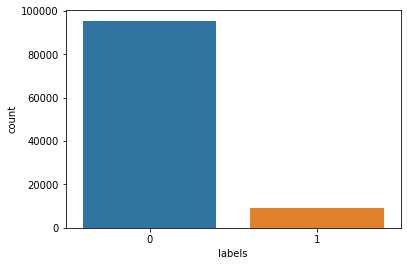

In [ ]:
# sns.countplot(x='labels', data=data)

In [ ]:
# data.head()

,words,labels
0,ражданин,0
1,ландафшиц,0
2,панцирт,0
3,girl,0
4,better,0


In [ ]:
# obscene = data[data.labels == 1]
# not_obscene = data[data.labels == 0]

In [ ]:
# len(obscene)

9075

In [ ]:
# len(not_obscene)

95547

In [ ]:
# len(data)

104622

### Подготовка данных

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(data.words, data.labels, test_size=0.05, random_state=42)

In [ ]:
# len(X_train), len(X_test), len(y_train), len(y_test)

(99390, 5232, 99390, 5232)

In [ ]:
# test_data = pd.DataFrame()
# test_data["words"] = X_test
# test_data["labels"] = y_test
# test_data.to_csv(test_data_path, index=False)

In [ ]:
# train_words, valid_words, train_targets, valid_targets = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
# len(train_words), len(valid_words)

(89451, 9939)

In [ ]:
# train_data = pd.DataFrame()
# train_data["words"] = train_words
# train_data["labels"] = train_targets
# train_data.to_csv(train_data_path, index=False)

# valid_data = pd.DataFrame()
# valid_data["words"] = valid_words
# valid_data["labels"] = valid_targets
# valid_data.to_csv(valid_data_path, index=False)

In [ ]:
train_data = pd.read_csv(train_data_path)
valid_data = pd.read_csv(valid_data_path)

train_words = train_data["words"]
train_targets = train_data["labels"]
valid_words = valid_data["words"] 
valid_targets = valid_data["labels"]

### Эмбеддинги

In [ ]:
fasttext = KeyedVectors.load(vector_model_path)

In [ ]:
!unzip /content/drive/MyDrive/thesis_datasets/obscene_6.05.21_1attempt.zip

Archive:  /content/drive/MyDrive/thesis_datasets/obscene_6.05.21_1attempt.zip
  inflating: obscene_model_best.pth  
  inflating: __MACOSX/._obscene_model_best.pth  
  inflating: obscene_model_last.pth  
  inflating: __MACOSX/._obscene_model_last.pth  
  inflating: obscene_opt_best.pth    
  inflating: __MACOSX/._obscene_opt_best.pth  
  inflating: obscene_opt_last.pth    
  inflating: __MACOSX/._obscene_opt_last.pth  
  inflating: obscene_vocab.json      
  inflating: __MACOSX/._obscene_vocab.json  


In [ ]:
# f = open("obscene_vocab.json", "r")
# file = f.read()
# f.close()  

# vocab = OrderedDict(json.loads(file))

In [ ]:
# vocab

In [ ]:
def get_embeddings(vocab, vector_model=fasttext):
    embeddings = [np.zeros(300)]
    
    for word in vocab:
        embeddings.append(vector_model[word])
    return embeddings

In [ ]:
embeddings = get_embeddings(vocab)

In [ ]:
len(embeddings)

124165

In [ ]:
def get_vocab_embeddings(words, vector_model=fasttext):
    vocab = {'<UNK>': 0}
    embeddings = [np.zeros(300)]
    
    for word in tqdm_notebook(words):
        if word not in vocab:
            vocab[word] = len(vocab)
            embeddings.append(vector_model[word])
    return vocab, embeddings

In [ ]:
%%time
vocab, embeddings = get_vocab_embeddings(data.words)


CPU times: user 5.61 s, sys: 654 ms, total: 6.27 s
Wall time: 5.63 s


In [ ]:
import pickle
with open('/content/drive/MyDrive/thesis_datasets/obscene_embeddings.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [ ]:
with open('/content/drive/MyDrive/thesis_datasets/obscene_embeddings.pickle', 'rb') as f:
    file_embeddings = pickle.load(f)

In [ ]:
embeddings = torch.tensor(file_embeddings).float()

In [ ]:
json_dump = json.dumps(vocab)
f = open(obscene_vocab_path, "w")
f.write(json_dump)
f.close()  

### Обработчик данных

In [ ]:
class BaddWordClassifierDataset(Dataset):
    
    def __init__(self, words, targets, vocab, unknown_index=0):
        super().__init__()
        
        self.words = words
        self.targets = targets
        self.vocab = vocab
        self.unknown_index = unknown_index
        
    def __len__(self):

        return len(self.words)

    def get_word_index(self, word):

        return self.vocab[word] if word in self.vocab else self.unknown_index
    
    def __getitem__(self, index):
       
        word = self.words[index]    
        index_of_word = self.get_word_index(word)
        converted_word = torch.tensor(index_of_word)

        target = self.targets[index]

        return converted_word, target

In [ ]:
train_dataset = BaddWordClassifierDataset(train_words, train_targets, vocab)
valid_dataset = BaddWordClassifierDataset(valid_words, valid_targets, vocab)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [ ]:
for x, y in train_loader:
    break

In [ ]:
x[0]

tensor(103779)

In [ ]:
y[0]

tensor(0)

### Модель

In [13]:
device = torch.device('cpu')

In [ ]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [14]:
class BaddObsceneNN(torch.nn.Module):
    
    def __init__(self, 
                 embeddings, 
                 num_classes, 
                 linear_size_1, 
                 linear_size_2):
        
        super().__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=False)

        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear1 = nn.Linear(in_features=embeddings.shape[-1], 
                                 out_features=linear_size_1,
                                 bias=False)
        self.linear2 = nn.Linear(in_features=linear_size_1, 
                                 out_features=linear_size_2,
                                 bias=False)
        self.relu = nn.ReLU()
        self.output_layer = torch.nn.Linear(in_features=linear_size_2,
                                            out_features=num_classes,
                                            bias=False)

        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        x = self.batch_norm(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        
        return x

In [16]:
num_classes = 1
linear_size_1 = 254
linear_size_2 = 128

In [31]:
obscene_model = BaddObsceneNN(embeddings, 
                 num_classes, 
                 linear_size_1, 
                 linear_size_2)
obscene_model.to(device)

BaddObsceneNN(
  (embedding_layer): Embedding(104623, 300)
  (batch_norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=300, out_features=254, bias=False)
  (linear2): Linear(in_features=254, out_features=128, bias=False)
  (relu): ReLU()
  (output_layer): Linear(in_features=128, out_features=1, bias=False)
)

### Обучение и валидация

In [ ]:
def binarize(pred):
    pred = pred.cpu().detach().numpy()
    result = []
    for r in pred:
        if r <= 0.5:
            result.append(0.)
        else:
            result.append(1.)
    return result

In [ ]:
def train_model(model, train_loader, optimizer, criterion, n_epoch, f_score_average, clip=3.0):

    train_losses = []
    f_scores_train = []

    model.train()
    
    train_progress_bar = tqdm_notebook(total=len(train_loader.dataset), desc=f'Epoch: {n_epoch + 1}, train', position=0, leave=True)
    

    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
            
        pred = model(x.detach())

        f_scores_train.append(f1_score(y.cpu().numpy(), binarize(pred), average=f_score_average))
        
        loss = criterion(pred.cpu().squeeze(), y.cpu().float())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())

        train_progress_bar.set_postfix(train_loss = np.mean(train_losses[-500:]))
        train_progress_bar.update(x.shape[0])

    train_progress_bar.close()

    return train_losses, f_scores_train

In [ ]:
def validate_model(model, valid_loader, optimizer, criterion, n_epoch, f_score_average):

    valid_losses = []
    f_scores_valid = []

    model.eval()

    valid_progress_bar = tqdm_notebook(total=len(valid_loader.dataset), desc=f'Epoch: {n_epoch + 1}, validation', position=0, leave=True)

    for x, y in valid_loader:

        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():  
            pred = model(x.detach())

        f_scores_valid.append(f1_score(y.cpu().numpy(), binarize(pred), average=f_score_average))
        loss = criterion(pred.cpu().squeeze(), y.cpu().float())

        valid_losses.append(loss.item())

        valid_progress_bar.set_postfix(valid_loss = np.mean(valid_losses[-500:]))
        valid_progress_bar.update(x.shape[0])
    
    valid_progress_bar.close()

    return valid_losses, f_scores_valid

In [ ]:
def save_model(model, optimizer, path_to_model_state, path_to_optimizer_state):
    torch.save(model.state_dict(), path_to_model_state)
    torch.save(optimizer.state_dict(), path_to_optimizer_state)

In [ ]:
def train_and_validate(model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       best_model_state_path,
                       best_opt_state_path,
                       last_model_state_path,
                       last_opt_state_path):

    val_losses = []
    tr_losses = []
    mean_f_scores_train = []
    mean_f_scores_valid = []
    best_val_loss = 10.0

    for n_epoch in range(n_epochs):

        epoch_train_losses, f_scores_train = train_model(model, train_loader, optimizer, criterion, n_epoch, f_score_average)
        epoch_valid_losses, f_scores_valid = validate_model(model, valid_loader, optimizer, criterion, n_epoch, f_score_average)

        mean_epoch_val_loss = np.mean(epoch_valid_losses)
        mean_f_scores_train.append(np.mean(f_scores_train))
        mean_f_scores_valid.append(np.mean(f_scores_valid))
        val_losses.append(mean_epoch_val_loss)
        tr_losses.append(np.mean(epoch_train_losses))

        scheduler.step()

        if mean_epoch_val_loss < best_val_loss:
            best_val_loss = mean_epoch_val_loss
            print(f"F-score on validation: {np.mean(f_scores_valid)}")
            save_model(model, optimizer, best_model_state_path, best_opt_state_path)
        else:
            print(f'Early stopping on epoch {n_epoch+1}')
            print(f"F-score on validation: {np.mean(f_scores_valid)}")
            save_model(model, optimizer, last_model_state_path, last_opt_state_path)
            break

    return val_losses, tr_losses, mean_f_scores_train, mean_f_scores_valid

In [ ]:
n_epochs = 30
model_params =  [x[1] for x in list(filter(lambda x: x[0] != 'embedding_layer.weight', obscene_model.named_parameters()))]
embedding_params = obscene_model.embedding_layer.parameters()
f_score_average = "micro"
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(params=[{'params': embedding_params, 'lr': 0.0001}, {'params': model_params, 'lr': 0.00001}])
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
%%time
valid_losses, train_losses, mean_f_scores_train, mean_f_scores_valid = train_and_validate(obscene_model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       obscene_model_best_state_path,
                       obscene_opt_best_state_path,
                       obscene_model_last_state_path,
                       obscene_opt_last_state_path)


F-score on validation: 0.9113786878282361



F-score on validation: 0.9111783673154156



F-score on validation: 0.9128810916743899



Early stopping on epoch 4
F-score on validation: 0.9162865403923386
CPU times: user 18min 50s, sys: 16.9 s, total: 19min 7s
Wall time: 19min 9s


### Графики

In [ ]:
def show_f_scores_graph(f_scores, training=True, epoch=True):
    plt.figure(figsize=(7, 7))
    plt.plot(f_scores)
    plt.grid()
    if training:
      plt.title('F-scores on train')
    else:
      plt.title('F-scores on validation')
    if epoch:
      plt.xlabel('Epochs')
    else:
      plt.xlabel('Iterations')
    plt.ylabel('f-score')

In [ ]:
def show_losses_graph(losses, training=True, epoch=True):
    plt.figure(figsize=(7, 7))
    plt.plot(losses)
    plt.grid()
    if training:
      plt.title('Training process')
    else:
      plt.title('Validation process')
    if epoch:
      plt.xlabel('Epochs')
    else:
      plt.xlabel('Iterations')
    plt.ylabel('Loss function')

CUDA

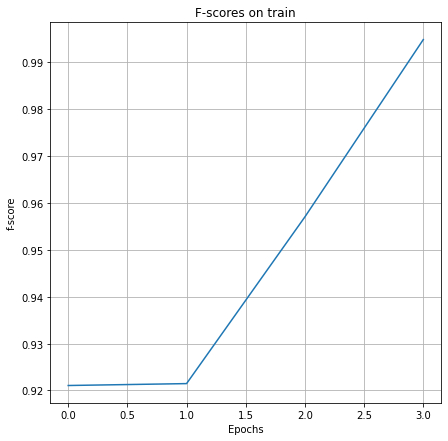

In [ ]:
show_f_scores_graph(mean_f_scores_train, training=True)

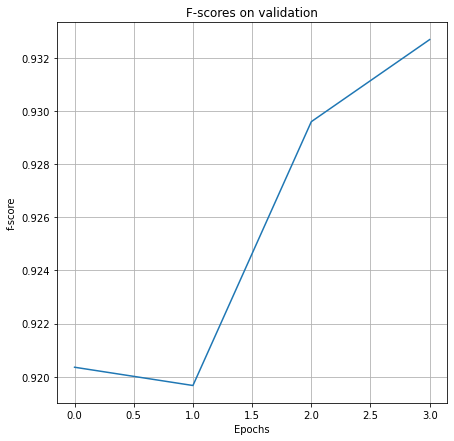

In [ ]:
show_f_scores_graph(mean_f_scores_valid, training=False)

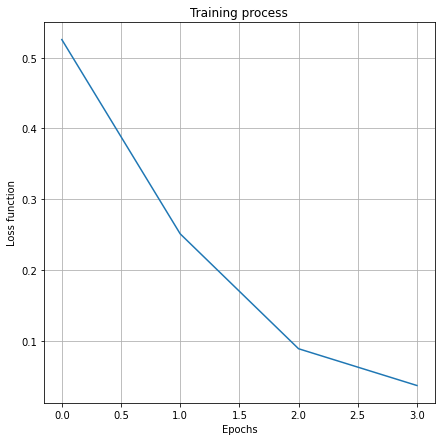

In [ ]:
show_losses_graph(train_losses, training=True)

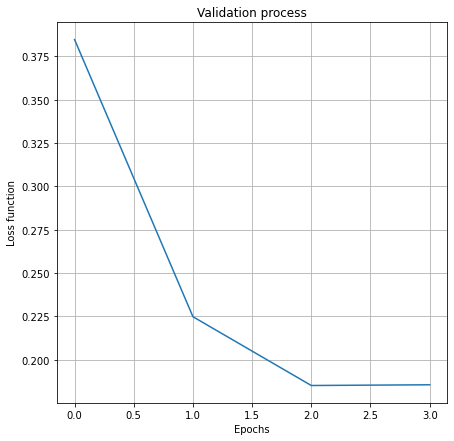

In [ ]:
show_losses_graph(valid_losses, training=False)

CPU

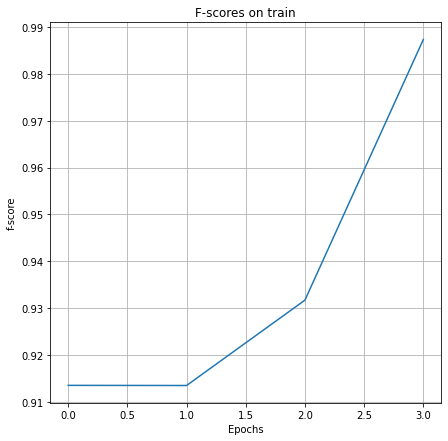

In [ ]:
show_f_scores_graph(mean_f_scores_train, training=True)

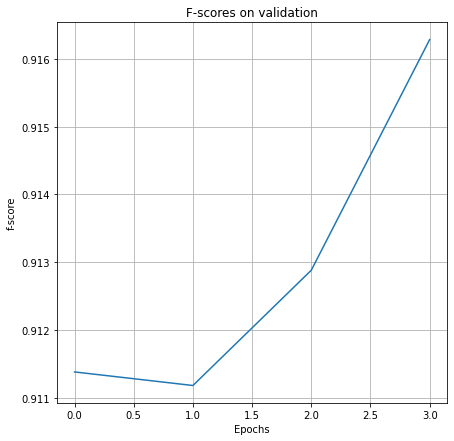

In [ ]:
show_f_scores_graph(mean_f_scores_valid, training=False)

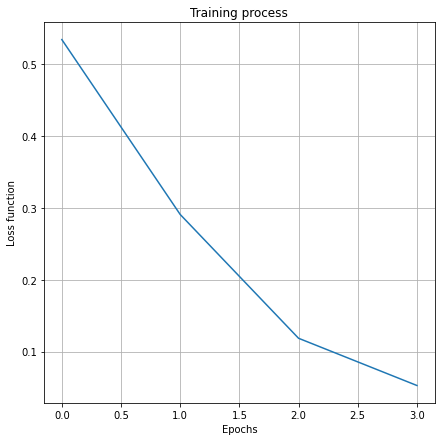

In [ ]:
show_losses_graph(train_losses, training=True)

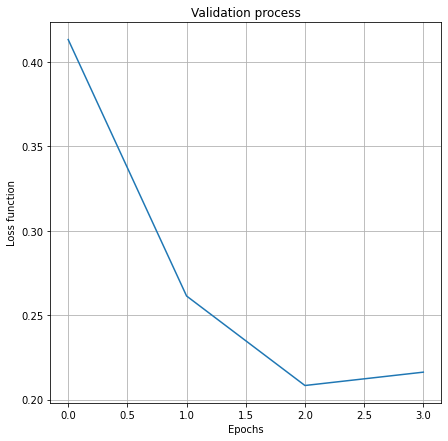

In [ ]:
show_losses_graph(valid_losses, training=False)

### Оценка модели

In [8]:
with open(obscene_embeddings_path, 'rb') as f:
    file_embeddings = pickle.load(f)

embeddings = torch.tensor(file_embeddings).float()

In [9]:
f = open(obscene_vocab_path, "r")
file = f.read()
f.close()  

vocab = json.loads(file)

In [10]:
test_data = pd.read_csv(test_data_path)

In [11]:
def load_model(path_to_model_state, path_to_optimizer_state):
    model_state = torch.load(path_to_model_state)
    optimizer_state = torch.load(path_to_optimizer_state)
    return model_state, optimizer_state

In [32]:
model, _ = load_model(obscene_model_best_state_path, obscene_opt_best_state_path)

In [33]:
obscene_model.load_state_dict(model)

<All keys matched successfully>

In [19]:
def binarize(pred):
    if pred > 0.5:
        return 1.
    else:
        return 0.

In [20]:
def predict_word(word, model, vocab=vocab):
    index = vocab[word] if word in vocab else 0
    tensor_index = torch.tensor(index)
    tensor_index = torch.unsqueeze(tensor_index,0)
    
    with torch.no_grad():
      pred = model.forward(tensor_index.to(device))
      pred = torch.sigmoid(pred).cpu().numpy()[0][0]
      pred = binarize(pred)
      return pred

In [21]:
def make_preds(model, words):
    model.eval()
    y_preds = []
    for word in words:
        y_preds.append(predict_word(word, model))
    return y_preds

In [22]:
%%time
y_preds = make_preds(obscene_model, test_data.words)
y_trues = test_data.labels

CPU times: user 912 ms, sys: 12 ms, total: 925 ms
Wall time: 994 ms


In [23]:
def evaluate_on_texts(y_trues, y_preds, f_score_average = "micro"):
    
    print(f"F1 score: {f1_score(y_trues, y_preds, average=f_score_average)}")
    print(f"Accuracy: {accuracy_score(y_trues, y_preds)}")
    print(classification_report(y_trues, y_preds))

In [24]:
evaluate_on_texts(y_trues, y_preds)

F1 score: 0.9202981651376146
Accuracy: 0.9202981651376146
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4777
           1       0.70      0.15      0.24       455

    accuracy                           0.92      5232
   macro avg       0.81      0.57      0.60      5232
weighted avg       0.90      0.92      0.90      5232



In [25]:
def probability_obscene(word, model, vocab=vocab):
    index = vocab[word] if word in vocab else 0
    tensor_index = torch.tensor(index)
    tensor_index = torch.unsqueeze(tensor_index,0)
    
    with torch.no_grad():
      pred = model.forward(tensor_index.to(device))
      pred = torch.sigmoid(pred).cpu().numpy()[0][0]
      return pred

obscene_model.eval()
words = ["собака", "охуенная", "кошка", "охуевшая", "человек", "пиздатый", "самолету", "пиздец"]
for word in words:
    print(probability_obscene(word, obscene_model))

0.009026027
0.7679707
0.0018637762
0.13320407
0.009996464
0.89088434
0.13320407
0.9387461


## Эксперимент с работой со сбалансированными классами

In [29]:
!unzip /content/drive/MyDrive/thesis_datasets/obscene_cpu_balanced.zip

Archive:  /content/drive/MyDrive/thesis_datasets/obscene_cpu_balanced.zip
  inflating: obscene_embeddings.pickle  
  inflating: __MACOSX/._obscene_embeddings.pickle  
  inflating: obscene_model_best_cpu_balanced.pth  
  inflating: __MACOSX/._obscene_model_best_cpu_balanced.pth  
  inflating: obscene_model_last_cpu_balanced.pth  
  inflating: __MACOSX/._obscene_model_last_cpu_balanced.pth  
  inflating: obscene_opt_best_cpu_balanced.pth  
  inflating: __MACOSX/._obscene_opt_best_cpu_balanced.pth  
  inflating: obscene_opt_last_cpu_balanced.pth  
  inflating: __MACOSX/._obscene_opt_last_cpu_balanced.pth  
  inflating: obscene_vocab_cpu.json  
  inflating: __MACOSX/._obscene_vocab_cpu.json  


In [30]:
obscene_model_best_state_path = "obscene_model_best_cpu_balanced.pth"
obscene_opt_best_state_path = "obscene_opt_best_cpu_balanced.pth"
obscene_model_last_state_path = "obscene_model_last_cpu_balanced.pth"
obscene_opt_last_state_path = "obscene_opt_last_cpu_balanced.pth"

In [ ]:
data = pd.concat([train_data, valid_data]).sample(frac=1)

In [ ]:
data.dropna(inplace=True)

In [ ]:
obscene = data[data.labels == 1]
not_obscene = data[data.labels == 0]

In [ ]:
len(obscene), len(not_obscene)

(8620, 90770)

In [ ]:
not_obscene = not_obscene.sample(10000, random_state=42)

In [ ]:
corpus = pd.concat([obscene, not_obscene]).sample(frac=1)

In [ ]:
corpus.head()

,words,labels
17136,рассеколить,1
9269,афкшитый,0
50288,припиздячить,1
80747,очки6,0
62563,провезти,0


In [ ]:
train_words, valid_words, train_targets, valid_targets = train_test_split(corpus.words.values.tolist(), corpus.labels.values.tolist(), test_size=0.1, random_state=42)

In [ ]:
len(train_words), len(valid_words)

(16758, 1862)

In [ ]:
train_dataset = BaddWordClassifierDataset(train_words, train_targets, vocab)
valid_dataset = BaddWordClassifierDataset(valid_words, valid_targets, vocab)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [ ]:
for x, y in valid_loader:
    break

In [ ]:
x[0]

tensor(21541)

In [ ]:
y[0]

tensor(1)

In [ ]:
obscene_model = BaddObsceneNN(embeddings, 
                 num_classes, 
                 linear_size_1, 
                 linear_size_2)
obscene_model.to(device)

BaddObsceneNN(
  (embedding_layer): Embedding(104623, 300)
  (batch_norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=300, out_features=254, bias=False)
  (linear2): Linear(in_features=254, out_features=128, bias=False)
  (relu): ReLU()
  (output_layer): Linear(in_features=128, out_features=1, bias=False)
)

In [ ]:
n_epochs = 30
model_params =  [x[1] for x in list(filter(lambda x: x[0] != 'embedding_layer.weight', obscene_model.named_parameters()))]
embedding_params = obscene_model.embedding_layer.parameters()
f_score_average = "micro"
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(params=[{'params': embedding_params, 'lr': 0.0001}, {'params': model_params, 'lr': 0.00001}])
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
%%time
valid_losses, train_losses, mean_f_scores_train, mean_f_scores_valid = train_and_validate(obscene_model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       obscene_model_best_state_path,
                       obscene_opt_best_state_path,
                       obscene_model_last_state_path,
                       obscene_opt_last_state_path)


F-score on validation: 0.5315178571428572



F-score on validation: 0.5537053571428571



F-score on validation: 0.6695982142857143



F-score on validation: 0.6710714285714285



F-score on validation: 0.7035119047619048



F-score on validation: 0.7179315476190475



F-score on validation: 0.7146279761904762



F-score on validation: 0.7100297619047619



F-score on validation: 0.7174107142857142



Early stopping on epoch 10
F-score on validation: 0.7133482142857143
CPU times: user 9min 46s, sys: 11.7 s, total: 9min 57s
Wall time: 10min 14s


CUDA

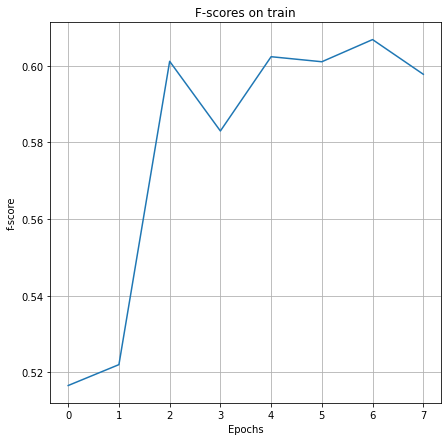

In [ ]:
show_f_scores_graph(mean_f_scores_valid, training=True)

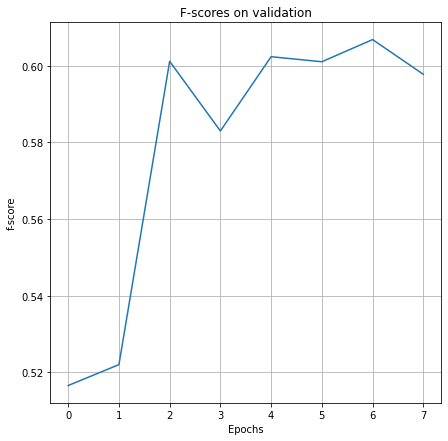

In [ ]:
show_f_scores_graph(mean_f_scores_valid, training=False)

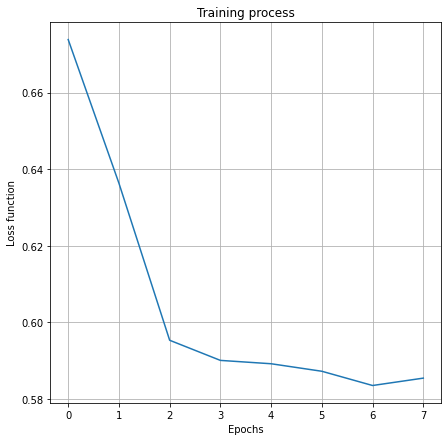

In [ ]:
show_losses_graph(valid_losses, training=True)

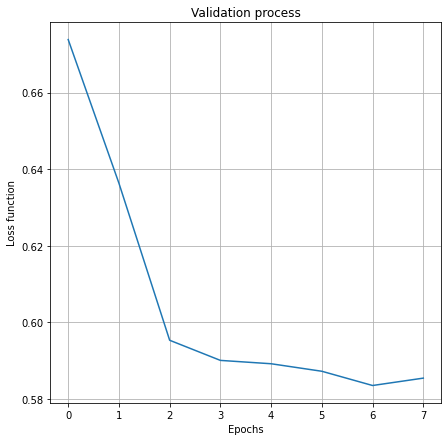

In [ ]:
show_losses_graph(valid_losses, training=False)

CPU

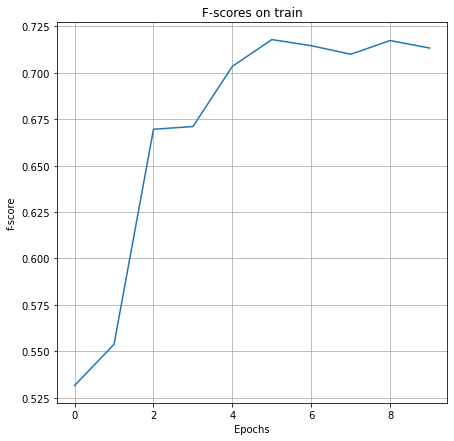

In [ ]:
show_f_scores_graph(mean_f_scores_valid, training=True)

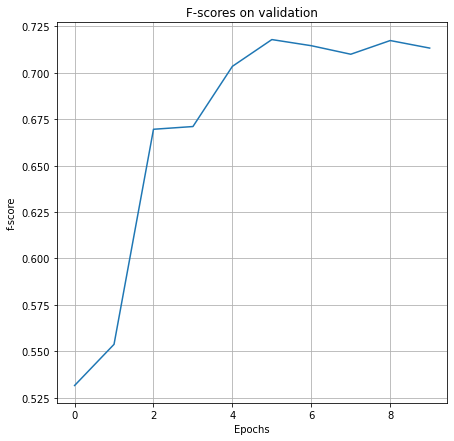

In [ ]:
show_f_scores_graph(mean_f_scores_valid, training=False)

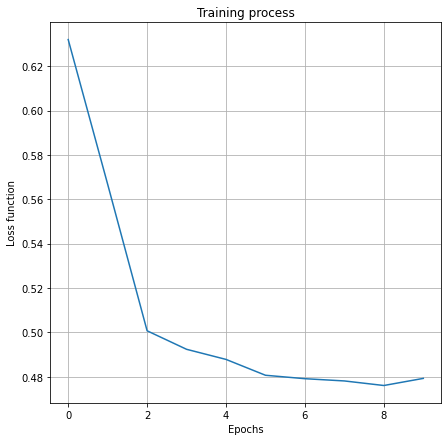

In [ ]:
show_losses_graph(valid_losses, training=True)

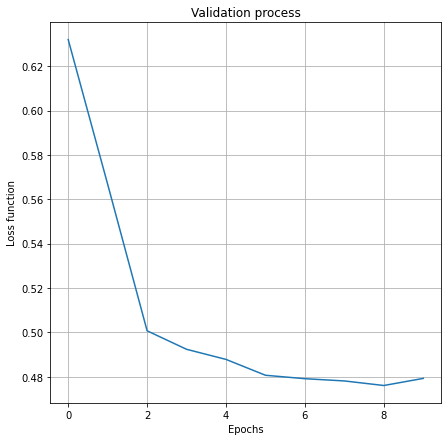

In [ ]:
show_losses_graph(valid_losses, training=False)

In [34]:
%%time
y_preds = make_preds(obscene_model, test_data.words)
y_trues = test_data.labels

CPU times: user 844 ms, sys: 13.4 ms, total: 857 ms
Wall time: 861 ms


In [35]:
evaluate_on_texts(y_trues, y_preds)

F1 score: 0.8985091743119266
Accuracy: 0.8985091743119266
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      4777
           1       0.43      0.56      0.49       455

    accuracy                           0.90      5232
   macro avg       0.70      0.74      0.72      5232
weighted avg       0.91      0.90      0.90      5232



## Выводы

Модель, обученная на несбалансированных данных, показала лучшие результаты, чем модель, обученная на сбалансированных данных